In [ ]:
from google.colab import drive
drive.mount('/content/my_drive')

In [ ]:
# Import libraries
import numpy as np
from keras import layers
from keras.models import Model
from keras.engine.topology import Layer
from keras.preprocessing.image import array_to_img, load_img, img_to_array
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [ ]:
class Denormalize(Layer):
    def __init__(self, **kwargs):
        super(Denormalize, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        return (x + 1) * 127.5
 
class InputNormalize(Layer):
    def __init__(self, **kwargs):
        super(InputNormalize, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def compute_output_shape(self,input_shape):
        return input_shape

    def call(self, x, mask=None):
        return x/255.
      

In [ ]:
class feedforward():
  def __init__(self, weight_path, width,height):
    self.weight_path = weight_path
    self.width = width
    self.height = height
    self.net = self.transform_net(self.width, self.height)
    self.net.load_weights(self.weight_path)
    
  def run(self, contrast, img_path):
    original_img = load_img(img_path, target_size = (self.width, self.height))
    contrast_img = self.change_contrast(original_img, contrast)
    img = np.expand_dims(contrast_img, axis = 0)
    res_img = self.net.predict(img)
    generated_img = array_to_img(res_img[0])
    
#   Return 3 images orginial image , image with new contrast, and generated image
    return original_img, contrast_img, generated_img

  def change_contrast(self, img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
      return 128 + factor * (c - 128)
    return img.point(contrast)

  def transform_net(self, img_width, img_height):
    input_tensor = layers.Input(shape=(img_width, img_height,3))
    input_tensor1 = InputNormalize()(input_tensor)
    
    x = layers.Conv2D(32, kernel_size = (9,9), strides = (1,1), padding = 'same')(input_tensor1)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(128, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = self.residual_block(x)
    x = self.residual_block(x)
    x = self.residual_block(x)
    x = self.residual_block(x)
    x = self.residual_block(x)
    
    x = layers.Conv2DTranspose(64, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2DTranspose(32, kernel_size = (3,3), strides = (2,2), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2DTranspose(3, kernel_size = (9,9), strides = (1,1), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    output_tensor = layers.Activation('tanh')(x)  
    
    output_tensor2 = Denormalize()(output_tensor)
    model = Model(inputs = input_tensor,outputs = output_tensor2)  
    return model

  def residual_block(self, x):
    y = x
    x = layers.Conv2D(128, kernel_size = (3,3), strides = (1,1), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(128, kernel_size = (3,3), strides = (1,1), padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    res = layers.merge.add([x, y])
    return res

In [ ]:
# Initialize the style weights and input size to the model
weight_path = '/content/82000_2picaso_style.h5'
model = feedforward(weight_path,1024,1024)

In [ ]:
img_path = '/content/a1.jpg'

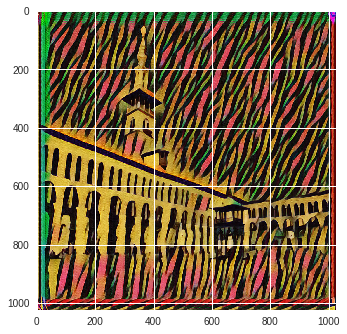

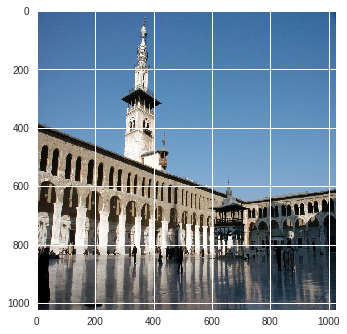

In [ ]:
original_img, contrast_img, res_img = model.run(0,img_path)
plt.imshow(res_img)
plt.figure()
plt.imshow(contrast_img)
plt.show()
res_img.save('/content/generated_img.jpg')
# contrast_img.save('/content/img_with_contrast.jpg')